In [3]:
pip install fredapi

In [4]:
pip install yfinance

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from fredapi import Fred

## Creates your "fred" object that can be used to pull data
fred = Fred(api_key='your API key here')

In [7]:
## Start and end dates for the date range we wish to pull data for
start = "1990-01-01"
end = "2023-07-05"

## Returns a dataframe with open, high, low, close, and volume for a given ticker
SPY = yf.Ticker("SPY")
SPY = SPY.history(start=start,end=end)
SPY.index = SPY.index.tz_localize(None)
SPY = SPY[['Close']]

## Code for adding a column that shows the future 1 year return
## Note there are roughly 252 trading days every single year
SPY['FUTURE_ANN_RETURN'] = SPY.Close.pct_change(periods=252)
SPY['FUTURE_ANN_RETURN'] = SPY['FUTURE_ANN_RETURN'].shift(-252)

In [8]:
## Creates a pandas dataframe for the federal funds rate
fed_funds_rate = pd.DataFrame(fred.get_series(
    'FEDFUNDS',
    observation_start=start,
    observation_end=end))
fed_funds_rate.columns = ['fed_funds_rate']

## Code for resampling and forward filling the federal funds rate to a daily view
fed_funds_rate['month'] = fed_funds_rate.index.strftime('%Y-%m')
start_date = fed_funds_rate.index.min() - pd.DateOffset(day=1)
end_date = fed_funds_rate.index.max() + pd.DateOffset(day=31)
dates = pd.date_range(start_date, end_date, freq='D')
dates.name = 'date'
fed_funds_rate = fed_funds_rate.reindex(dates, method='ffill')
fed_funds_rate = fed_funds_rate.drop(['month'], axis=1)

In [9]:
## Combine both dataframes
COMBINED_DF = pd.merge(SPY, fed_funds_rate, left_index=True, right_index=True)
COMBINED_DF = COMBINED_DF.dropna()
COMBINED_DF.head()

,Close,FUTURE_ANN_RETURN,fed_funds_rate
1993-01-29,24.941387,0.114069,3.02
1993-02-01,25.118769,0.109097,3.03
1993-02-02,25.172003,0.114698,3.03
1993-02-03,25.438089,0.097319,3.03
1993-02-04,25.544529,0.099867,3.03


In [10]:
X = COMBINED_DF['fed_funds_rate'].values.reshape(-1, 1)
Y = COMBINED_DF['FUTURE_ANN_RETURN'].values

In [11]:
model = LinearRegression()
model.fit(X,Y)
predictions = model.predict(X)
coefs = model.coef_[0]

print('coefficients : ',coefs)
print('mean_absolute_error : ', mean_absolute_error(Y, predictions))
print('r2_score : ', r2_score(Y, predictions))

coefficients :  -0.005274982528305382
mean_absolute_error :  0.12982200889969456
r2_score :  0.0045753824013300415


In [12]:
COMBINED_DF = pd.merge(SPY, fed_funds_rate, left_index=True, right_index=True)
COMBINED_DF['fed_funds_rate_ly'] = COMBINED_DF.fed_funds_rate.shift(252)
COMBINED_DF = COMBINED_DF.dropna()
COMBINED_DF.head()

,Close,FUTURE_ANN_RETURN,fed_funds_rate,fed_funds_rate_ly
1994-01-27,27.786421,0.012923,3.05,3.02
1994-01-28,27.859159,0.005921,3.05,3.03
1994-01-31,28.059193,0.002743,3.05,3.03
1994-02-01,27.913694,0.007635,3.25,3.03
1994-02-02,28.095573,0.007092,3.25,3.03


In [13]:
X = COMBINED_DF['fed_funds_rate_ly'].values.reshape(-1, 1)
Y = COMBINED_DF['FUTURE_ANN_RETURN'].values

model = LinearRegression()
model.fit(X,Y)
predictions = model.predict(X)
coefs = model.coef_[0]

print('coefficients : ',coefs)
print('mean_absolute_error : ', mean_absolute_error(Y, predictions))
print('r2_score : ', r2_score(Y, predictions))

coefficients :  -0.013382202645349308
mean_absolute_error :  0.13132147071171926
r2_score :  0.028656235078729386


In [14]:
COMBINED_DF = pd.merge(SPY, fed_funds_rate, left_index=True, right_index=True)

def periods_above(data,col,threshold = 1):
  """
  loops through a column of a dataframe and returns a list that shows the number of consecutive periods/observations/rows where the value is above a given threshold
  """
  periods_above = []

  count = 0

  for i in data[col]:
    if i > threshold:
      count += 1
      periods_above.append(count)
    else:
      periods_above.append(0)
      count = 0
  return periods_above

for i in range(1,6):
  COMBINED_DF['DAYS_ABOVE_' + str(i)] = periods_above(COMBINED_DF,"fed_funds_rate",threshold = i)

COMBINED_DF.head()

,Close,FUTURE_ANN_RETURN,fed_funds_rate,DAYS_ABOVE_1,DAYS_ABOVE_2,DAYS_ABOVE_3,DAYS_ABOVE_4,DAYS_ABOVE_5
1993-01-29,24.941387,0.114069,3.02,1,1,1,0,0
1993-02-01,25.118769,0.109097,3.03,2,2,2,0,0
1993-02-02,25.172003,0.114698,3.03,3,3,3,0,0
1993-02-03,25.438089,0.097319,3.03,4,4,4,0,0
1993-02-04,25.544529,0.099867,3.03,5,5,5,0,0


In [15]:
COMBINED_DF = COMBINED_DF.dropna()

X = COMBINED_DF.iloc[:,3:].values
Y = COMBINED_DF['FUTURE_ANN_RETURN'].values

X = sm.add_constant(X)
model = sm.OLS(Y,X)
model = model.fit()

predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     393.4
Date:                Wed, 29 Nov 2023   Prob (F-statistic):               0.00
Time:                        18:33:10   Log-Likelihood:                 3430.9
No. Observations:                7409   AIC:                            -6850.
Df Residuals:                    7403   BIC:                            -6808.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1415      0.002     61.469      0.000       0.137       0.146
x1         -3.442e-05   2.94e-06    -11.712      0.000   -4.02e-05   -2.87e-05
x2            -0.0001   9.49e-06    -13.117      0.000      -0.000      -0.000
x3         -9.945e-06   1.35e-05     -0.734      0.463   -3.65e-05    1.66e-05
x4          4.996e-05   1.02e-05      4.878      0.000    2.99e-05       7e-05
x5             0.0004   1.06e-05     33.159      0.000       0.000       0.000
==============================================================================
Omnibus:                      136.380   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              178.572
Skew:                          -0.243   Prob(JB):                     1.67e-39
Kurtosis:                       3.585   Cond. No.                     1.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'Predictions vs Actual')

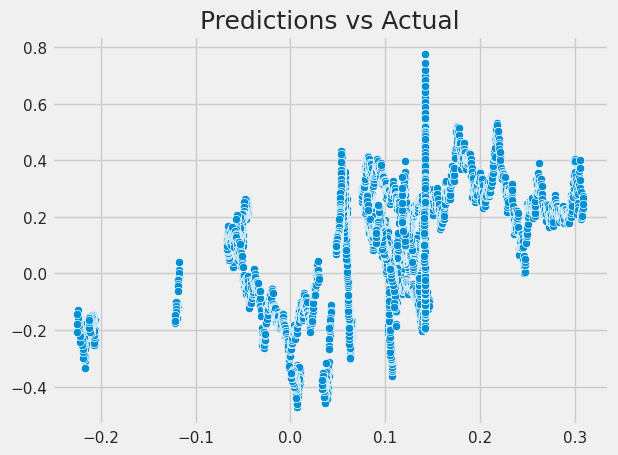

In [16]:
plt.style.use('fivethirtyeight')
plot = sns.scatterplot(x=predictions,y=Y)
plot.set_title('Predictions vs Actual', fontsize=18)